In [220]:
import pathlib
import json
import rich
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.2)
sns.set_palette(sns.color_palette("Set2", desat=0.8))

def human_format_nb(num: float, precision: int = 0) -> str:
    """Converts a number to a human-readable format."""
    if num is None:
        return "none"
    magnitude = 0
    base = 1000.0
    while abs(num) >= base:
        magnitude += 1
        num /= base
    # add more suffixes if you need them
    q = ["", "K", "M", "G", "T", "P"][magnitude]
    return f"{num:.{precision}f}{q}"


def _proc_nvecs_train(row):
    nvecs = human_format_nb(row['args_nvecs'])
    ntrain = human_format_nb(row['args_train_size'])
    if ntrain == "nan":
        return f"N={nvecs}, train=max"
    return  f"N={nvecs}, train={ntrain}"

def _flatten_nested_dict(d, parent_key="", sep="_"):
    """Flatten a nested dict."""
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(_flatten_nested_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

path = pathlib.Path("/Users/vlievin/data/remote_data/faiss_factory_benchmark.jsonl")
data = []
with path.open() as f:
    for line in f:
        d = json.loads(line)
        d = _flatten_nested_dict(d)
        data.append(d)

df = pd.DataFrame(data)
df = df[df['args_factory'] != 'OPQ32_512,IVFauto,PQ32x8']
df['times_search'] = 1000 * df['times_search']
df['times_build'] =  df['times_build'] / 60
df['nvecs_train'] = df.apply(_proc_nvecs_train, axis=1)
df.head()

,times_build,times_search,args_nvecs,args_vdim,args_init_bs,args_train_size,args_prep,args_factory,args_nprobe,args_nthreads,...,args_pre_tables,args_use_float16,args_verbose,args_serve_on_gpu,cuda_device,cuda_n_devices,cuda_version,mem_usage,status,nvecs_train
0,0.945969,65.989964,1000000,512,1000,NaN,None,"IVFauto,Flat",32,16,...,False,True,False,False,NVIDIA A100-SXM4-40GB,1,11.7,6.705990,success,"N=1M, train=max"
1,0.811190,46.061917,1000000,512,1000,NaN,None,"IVFauto,PQ32x8",32,16,...,False,True,False,False,NVIDIA A100-SXM4-40GB,1,11.7,-0.446735,success,"N=1M, train=max"
2,3.100564,46.447420,1000000,512,1000,NaN,None,"OPQ32,IVFauto,PQ32x8",32,16,...,False,True,False,False,NVIDIA A100-SXM4-40GB,1,11.7,-0.412819,success,"N=1M, train=max"
3,0.981572,17.360304,1000000,512,1000,NaN,None,"IVFauto,Flat",32,16,...,False,True,False,True,NVIDIA A100-SXM4-40GB,1,11.7,3.866741,success,"N=1M, train=max"
4,0.875344,16.610562,1000000,512,1000,NaN,None,"IVFauto,PQ32x8",32,16,...,False,True,False,True,NVIDIA A100-SXM4-40GB,1,11.7,1.811077,success,"N=1M, train=max"


['N=1M, train=max', 'N=10M, train=1M', 'N=10M, train=max']

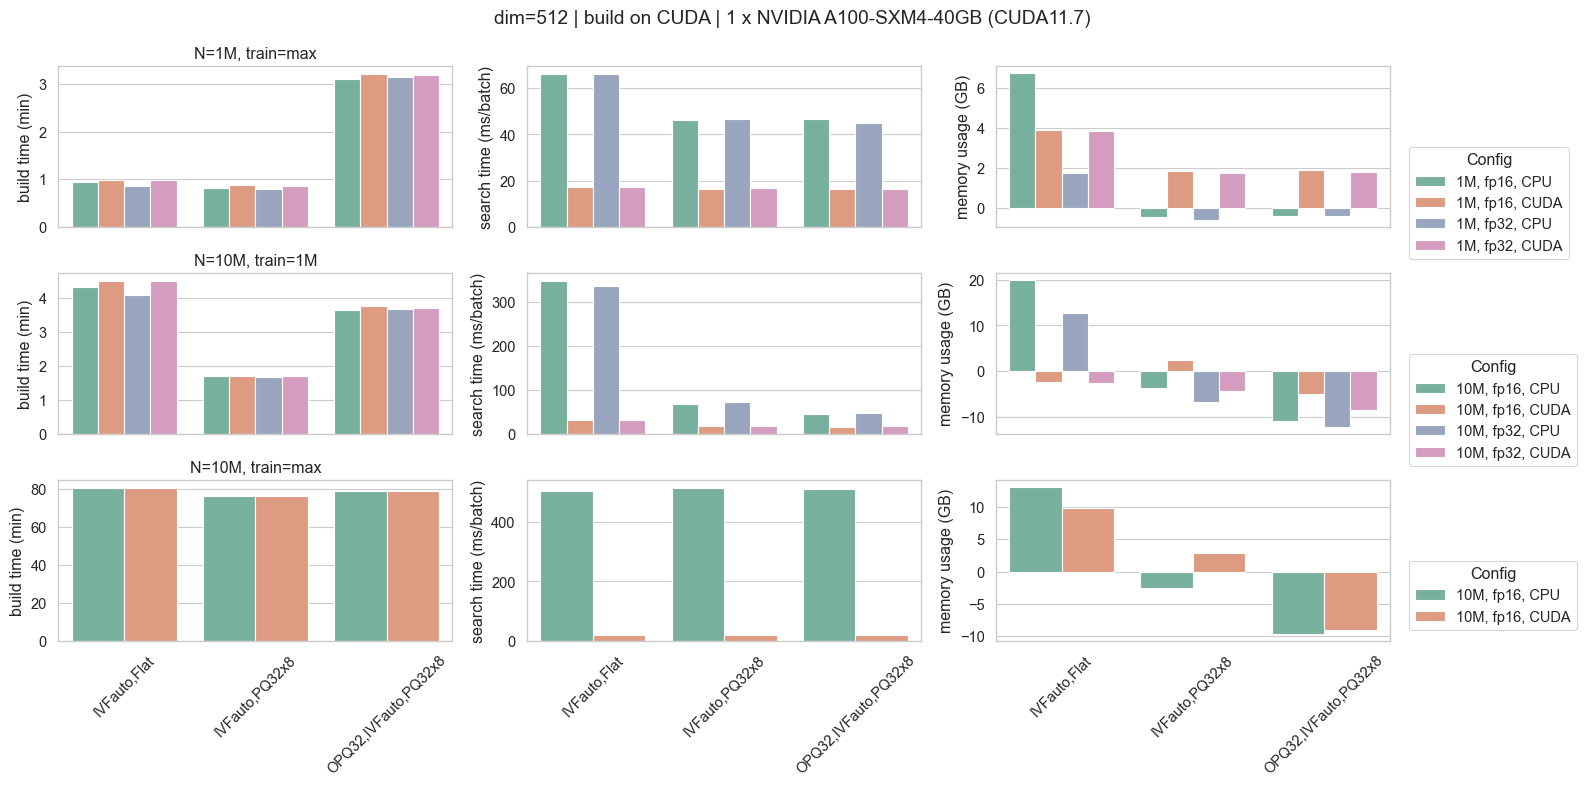

In [226]:



lookup = {
    ("args_serve_on_gpu", True):  "CUDA",
    ("args_serve_on_gpu", False):  "CPU",
    ("args_use_float16", True):  "fp16",
    ("args_use_float16", False):  "fp32",
    "args_nvecs": human_format_nb,
}
def _trans(k, v):
    if (k,v) in lookup:
        return lookup[(k,v)]
    else:
        return lookup[k](v)

def _collate_fields(sub):
    x = [_trans(k,v) for k, v in sub.items() if k.startswith("args_")]
    return f"{', '.join([y for y in x if y is not None])}"


vec_sizes = list(df['nvecs_train'].unique())
rich.print(vec_sizes)
fig, raxes = plt.subplots(len(vec_sizes), 3, figsize=(16, 8), sharex=True, sharey=False)
fig.suptitle(f"dim={df['args_vdim'].unique()[0]} | build on CUDA | {df['cuda_n_devices'].unique()[0]} x {df['cuda_device'].unique()[0]} (CUDA{df['cuda_version'].unique()[0]})")
for i, v in enumerate(vec_sizes):
    df_ = df[(df['nvecs_train'] == vec_sizes[i])& (df['args_factory'] != 'OPQ32_512,IVFauto,PQ32x8')
    hue = df_[['args_nvecs', 'args_use_float16', 'args_serve_on_gpu' ]].apply(_collate_fields, axis=1)
    axes = raxes[i]
    axes[0].set_title(vec_sizes[i])
    g= sns.barplot(data=df_, x="args_factory", y="times_build", hue=hue, ax=axes[0])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_ylabel("build time (min)") 
    g.set_xlabel("")
    g.legend([],[], frameon=False)
    g = sns.barplot(data=df_, x="args_factory", y="times_search", hue=hue, ax=axes[1])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_ylabel("search time (ms/batch)")
    g.set_xlabel("")
    g.legend([],[], frameon=False)
    g = sns.barplot(data=df_, x="args_factory", y="mem_usage", hue=hue, ax=axes[2])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_ylabel("memory usage (GB)")
    g.set_xlabel("")
    # change legend location
    axes[2].legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0., title="Config")

plt.tight_layout()
plt.savefig("faiss_factory_benchmark.png")
plt.show()

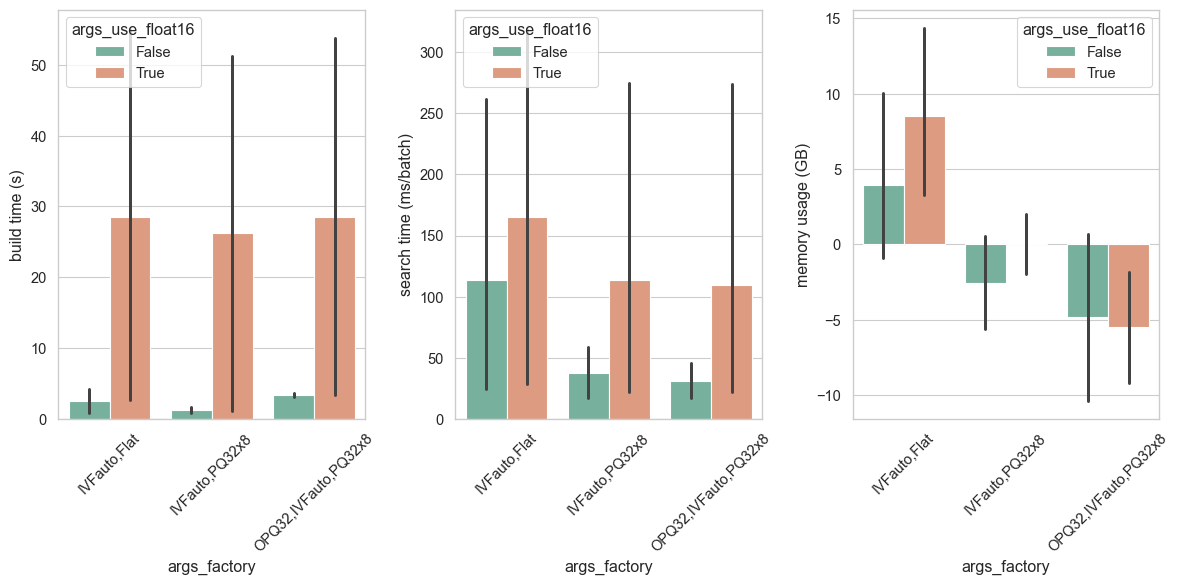

In [208]:

hue = "args_use_float16"
df_ = df
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
g= sns.barplot(data=df_ , x="args_factory", y="times_build", hue=hue, ax=axes[0])
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_ylabel("build time (s)")
g = sns.barplot(data=df_ , x="args_factory", y="times_search", hue=hue, ax=axes[1])
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_ylabel("search time (ms/batch)")
g = sns.barplot(data=df_ , x="args_factory", y="mem_usage", hue=hue, ax=axes[2])
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_ylabel("memory usage (GB)")
plt.tight_layout()
plt.show()
